In [1]:
import mne
import numpy as np

### Info-Dump


- 2 Task: Regularity, Luminance
- 2 Angle: Frontoparallel, Perspective
  
- 2 Regularity: Symmetry, Asymmetry -> Discriminate symmetry from asymmetry
- 2 Luminance: Dark, Light          -> Discriminate dark from light stimuli 

Task and Angle were blocked. -> One data file per combination (Lumfron, Lumperp etc.)

- Lumfront
- LumPerp
- RegFront
- RegPerp

Events in each task: "Combination of reflection and color conditions"
- RAND_DARK
- RAND_LIGHT
- REF_DARK
- REF_LIGHT

Hypothesis of what the event types are (not 100% sure!!)
| Event label  | Likely meaning                                   | Context                           |
| ------------ | ------------------------------------------------ | --------------------------------- |
| `RAND_DARK`  | Asymmetrical (random) pattern, dark luminance    | Regularity task or Luminance task |
| `RAND_LIGHT` | Asymmetrical (random) pattern, light luminance   | ""                                |
| `REF_DARK`   | Symmetrical (reflected) pattern, dark luminance  | ""                                |
| `REF_LIGHT`  | Symmetrical (reflected) pattern, light luminance | ""                                |

In Regularity task blocks:
- Participants attend to symmetry, ignore luminance (but events still mark both features).

In Luminance task blocks:
- Participants attend to light/dark, ignore regularity (but events still mark both features).


After above tasks, this was done to check EEG data quality in VR compared to monitor (not included in hypothesis testing)
- Signalscreen  -> Monitor
- Signalvr      -> With VR headset on



### Questions

Are there only 4 events/stimuli per file/task type?? Why is it recorded for a much longer time then?

In [2]:
from mne_bids import BIDSPath, read_raw_bids

bids_root = r"ds005841-download"

subject_id = "001"
task = "regfront"    # lumfront, lumperp, regfront, regperp, signalscreen, signalvr -> Was ist signalscreen, signalvr?

bids_path = BIDSPath(
    subject=subject_id,
    task=task,
    datatype="eeg",
    suffix="eeg",
    extension=".bdf",
    root=bids_root
)

print(bids_path.fpath)

raw = read_raw_bids(bids_path)
raw.load_data();

ds005841-download\sub-001\eeg\sub-001_task-regfront_eeg.bdf
Extracting EDF parameters from d:\lisa-\Universität_2\Master\2. Semester\EEG\EEG_Project\ds005841-download\sub-001\eeg\sub-001_task-regfront_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from ds005841-download\sub-001\eeg\sub-001_task-regfront_events.tsv.
Reading 0 ... 183807  =      0.000 ...   358.998 secs...


C:\Users\lisa-\AppData\Local\Temp\ipykernel_12916\2182360686.py:19: RuntimeWarning: Did not find any channels.tsv associated with sub-001_task-regfront.

The search_str was "ds005841-download\sub-001\**\eeg\sub-001*channels.tsv"
  raw = read_raw_bids(bids_path)


In [3]:
events, event_id = mne.events_from_annotations(raw)
print(event_id)

Used Annotations descriptions: [np.str_('RAND_DARK'), np.str_('RAND_LIGHT'), np.str_('REF_DARK'), np.str_('REF_LIGHT')]
{np.str_('RAND_DARK'): 1, np.str_('RAND_LIGHT'): 2, np.str_('REF_DARK'): 3, np.str_('REF_LIGHT'): 4}


In [ ]:
for ann in raw.annotations:
    print(f"{ann['description']}: onset={ann['onset']}, duration={ann['duration']}")

In [ ]:
print(raw.info['ch_names'])

Using matplotlib as 2D backend.


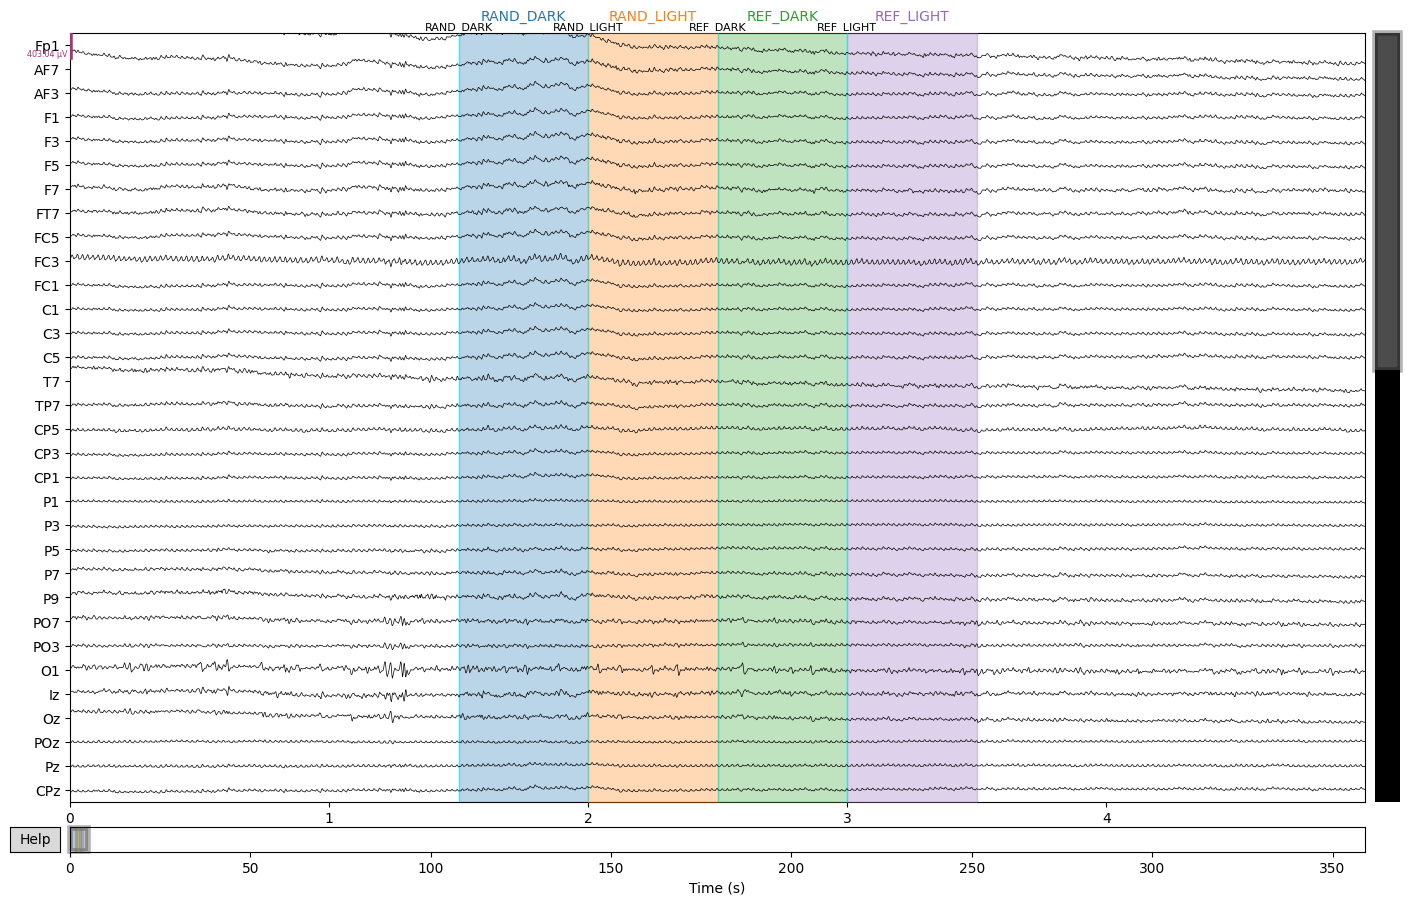

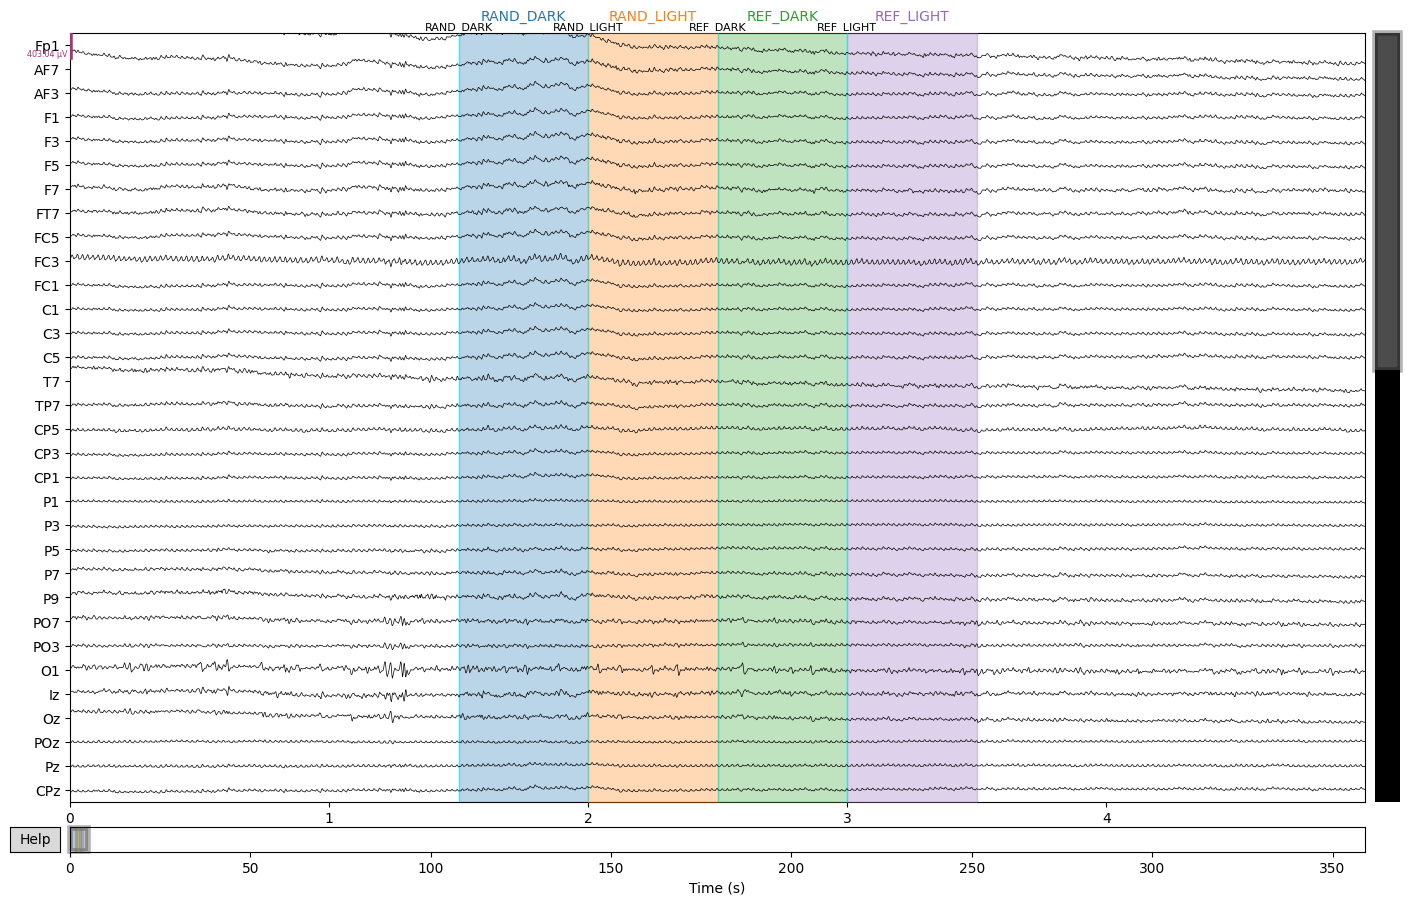

In [4]:
#%matplotlib qt
raw.plot(events=events, event_id=event_id, block=True, scalings='auto', duration=5, n_channels=32)

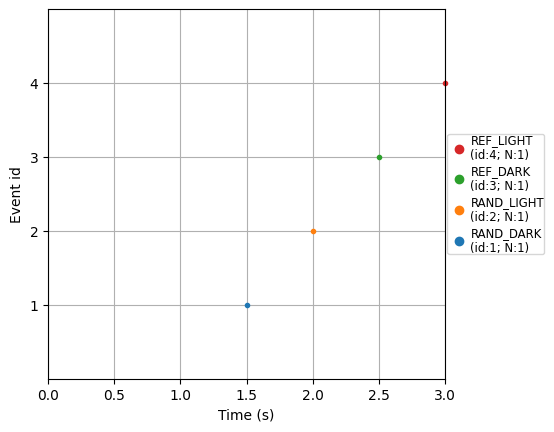

In [5]:
fig = mne.viz.plot_events(
    events, event_id=event_id, sfreq=raw.info["sfreq"], first_samp=raw.first_samp
)

In [15]:
# Extract all events from stim channel 'Status'
events_from_stim = mne.find_events(raw, stim_channel='Status', shortest_event=1)

print(f"Total events found: {len(events_from_stim)}")
print("First 10 events:\n", events_from_stim[:10])

# Count number of trials per event
for code, label in event_id.items():
    n_trials = np.sum(events_from_stim[:, 2] == code)
    print(f"{label}: {n_trials} trials")


%matplotlib qt
raw.plot(
    events=events_from_stim,   # show all stimulus events
    event_id=event_id,      
    event_color='red',        
    duration=10,               
    block=True,                
    scalings='auto',           
    n_channels=32
)

Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
129 events found on stim channel Status
Event IDs: [ 1  2  3  4 55]
Total events found: 129
First 10 events:
 [[ 3430     0    55]
 [ 4201     0     2]
 [ 5482     0     4]
 [ 6734     0     3]
 [ 8111     0     1]
 [18481     0     1]
 [20076     0     2]
 [21306     0     4]
 [23296     0     3]
 [24599     0     2]]
1: 0 trials
2: 0 trials
3: 0 trials
4: 0 trials
Channels marked as bad:
none


KeyboardInterrupt: 

C:\Users\lisa-\AppData\Local\Temp\ipykernel_12916\2835450944.py:1: RuntimeWarning: event 55 missing from event_id will be ignored
  fig = mne.viz.plot_events(


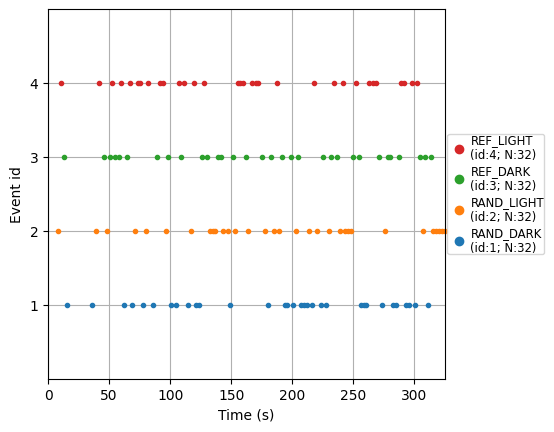

In [8]:
fig = mne.viz.plot_events(
    events_from_stim, event_id=event_id, sfreq=raw.info["sfreq"], first_samp=raw.first_samp
)

In [12]:
stim_mask = np.isin(events_from_stim[:, 2], list(event_id.keys()))
events_stim_only = events_from_stim[stim_mask]

# Then create annotations
onsets = events_stim_only[:, 0] / raw.info['sfreq']
durations = np.repeat(0.5, len(events_stim_only))
descriptions = [event_id[code] for code in events_stim_only[:, 2]]

annotations = mne.Annotations(onset=onsets, duration=durations, description=descriptions)
raw.set_annotations(annotations)

<RawEDF | sub-001_task-regfront_eeg.bdf, 73 x 183808 (359.0 s), ~102.4 MiB, data loaded>

In [14]:
raw.plot(events=events, event_id=event_id, block=True, scalings='auto', duration=5, n_channels=32)

Channels marked as bad:
none


KeyboardInterrupt: 

In [19]:
import ccs_eeg_utils

bids_root = "ds005841-download"

subject_id = "001"
task = "regfront"   # lumfront, lumperp, regfront, regperp, signalscreen, signalvr

bids_path = BIDSPath(
    subject=subject_id,
    task=task,
    datatype="eeg",
    suffix="eeg",
    extension=".bdf",
    root=bids_root
)

# Load raw
raw = read_raw_bids(bids_path)
raw.load_data()

# Load events from events.tsv
ccs_eeg_utils.read_annotations_core(bids_path, raw)

print(raw.annotations)

# Visualize with event annotations
raw.plot(events=events, event_id=event_id, block=True, scalings='auto', duration=5, n_channels=32)

Extracting EDF parameters from d:\lisa-\Universität_2\Master\2. Semester\EEG\EEG_Project\ds005841-download\sub-001\eeg\sub-001_task-regfront_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from ds005841-download\sub-001\eeg\sub-001_task-regfront_events.tsv.
Reading 0 ... 183807  =      0.000 ...   358.998 secs...


C:\Users\lisa-\AppData\Local\Temp\ipykernel_12916\927959720.py:18: RuntimeWarning: Did not find any channels.tsv associated with sub-001_task-regfront.

The search_str was "ds005841-download\sub-001\**\eeg\sub-001*channels.tsv"
  raw = read_raw_bids(bids_path)


<Annotations | 4 segments: RAND_DARK (1), RAND_LIGHT (1), REF_DARK (1), ...>
Channels marked as bad:
none


KeyboardInterrupt: 